<a href="https://colab.research.google.com/github/r-zambotti/Tech_Challenge_4_Fase/blob/main/Tech_Challenge_Data_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tech Challenge - Data Viz - 4ª Fase**

## **1 - Introdução**

- A análise visa realizar a previsão dos valores futuros de fechamento do período diário da IBOVESPA através de algoritmos de machine learning.

  ## **2 - 	Objetivo Geral**

Realizar a análise exploratória robusta em busca de aprimorar o entendimento dos dados, criar um modelo preditivo através de algoritmos de machine learning com dados da IBOVESPA para criar uma série temporal e prever diariamente o fechamento da base.

 E com base na análise demonstrar para o time de investimentos os seguintes pontos:
- O modelo com o storytelling, desde a captura do dado até a entrega do modelo.
- Justificar a técnica utilizada.
- Atingir uma acuracidade adequada (acima de 70%).

## **3 - Material e Ferramentas**

Embasando na robustez deste relatório, a base de dados utilizados nesta análise foi extraída da fonte do site da investing, sugerido para este trabalho com o período diário e com um intervalo de 20 anos assim atingindo uma maior acuracidade no modelo preditivo.

Para a análise foram usadas ferramentas de suma importância no cenário de análise de dados, tais como: Google Colab, Python.

## 4 - Importação dos dados

### 4.1 - Bibliotecas

In [1]:
# Instalação bibliotecas necessarias

%pip install requests beautifulsoup4 pandas
%pip install statsforecast
%pip install pmdarima
%pip install -U scikit-learn
%pip install plotly==5.24.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00


In [2]:
# Importando bibliotecas necessarias
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
import seaborn as sns

from pmdarima import auto_arima

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score


from plotly.subplots import make_subplots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.ticker as ticker


from prophet import Prophet
from prophet.plot import plot_plotly


### 4.2 - Import base de dados

- Importando o DataSet direto da pagina do IPEA

In [3]:
# URL da página do ipeadata
url = "http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view"

# Fazendo a requisição HTTP para a página
response = requests.get(url)

# Verificando o status da requisição
if response.status_code == 200:
    print("Conexão bem-sucedida!")
else:
    print(f"Erro ao acessar a página: {response.status_code}")

# Parseando o HTML com BeautifulSoup
soup = BeautifulSoup(response.content, "html.parser")

# Buscando a tabela na página
table = soup.find("table", {"class": "dxgvTable"})  # Identifique a classe correta da tabela
if table:
    # Extraindo os dados da tabela
    rows = table.find_all("tr")
    data = []

    # Iterando pelas linhas da tabela
    for row in rows:
        cols = row.find_all("td")
        cols = [col.text.strip() for col in cols]
        if cols:  # Ignorar linhas vazias
            data.append(cols)

    # Convertendo os dados para um DataFrame do pandas
    columns = ["Data", "Preço","drop1","drop2","drop3","drop4"]  # Ajuste conforme as colunas da tabela
    df_dados = pd.DataFrame(data, columns=columns)

    # Deletando as colunas
    df_dados = df_dados.drop(columns=["drop1","drop2","drop3","drop4"])

    # Deletando as 3 primeiras linhs
    df_dados = df_dados.iloc[3:]

    # Exibindo os primeiros e ultimos registros
    print(df_dados)

    # Salvando os dados em um arquivo CSV
    df_dados.to_csv("dados_petroleo.csv", index=False)
    print("Dados salvos em 'dados_petroleo.csv'.")
else:
    print("Tabela não encontrada na página.")


Conexão bem-sucedida!
             Data  Preço
3      25/11/2024  74,27
4      22/11/2024  76,10
5      21/11/2024  75,09
6      20/11/2024  74,33
7      19/11/2024  74,32
...           ...    ...
11305  26/05/1987  18,63
11306  25/05/1987  18,60
11307  22/05/1987  18,55
11308  21/05/1987  18,45
11309  20/05/1987  18,63

[11307 rows x 2 columns]
Dados salvos em 'dados_petroleo.csv'.


In [ ]:
df_dados

,Data,Preço
3,18/11/2024,"74,35"
4,15/11/2024,"73,45"
5,14/11/2024,"73,39"
6,13/11/2024,"72,86"
7,12/11/2024,"72,56"
...,...,...
11300,26/05/1987,"18,63"
11301,25/05/1987,"18,60"
11302,22/05/1987,"18,55"
11303,21/05/1987,"18,45"


In [ ]:
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11302 entries, 3 to 11304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    11302 non-null  object
 1   Preço   11302 non-null  object
dtypes: object(2)
memory usage: 176.7+ KB


## 5 - Analise exploratória  e Tratamento dos Dados

In [4]:
# Renomeando as colunas
df_ipea = df_dados.rename(columns={"Data": "data", "Preço": "preco"})

# Convertendo a coluna 'data' para o tipo datetime
df_ipea["data"] = pd.to_datetime(df_ipea["data"], format="%d/%m/%Y")

# Convertendo a coluna 'preco' para float
df_ipea['preco'] = df_ipea['preco'].str.replace(',', '.').astype(float)


In [ ]:
df_ipea

,data,preco
3,2024-11-18,74.35
4,2024-11-15,73.45
5,2024-11-14,73.39
6,2024-11-13,72.86
7,2024-11-12,72.56
...,...,...
11300,1987-05-26,18.63
11301,1987-05-25,18.60
11302,1987-05-22,18.55
11303,1987-05-21,18.45


In [ ]:
df_ipea.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11302 entries, 3 to 11304
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   data    11302 non-null  datetime64[ns]
 1   preco   11302 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 176.7 KB


In [ ]:
print("Quantidade de linhas e colunas: ", df_ipea.shape)

Quantidade de linhas e colunas:  (11302, 2)


In [ ]:
print("Estatísticas descritivas: ")
df_ipea.describe()

Estatísticas descritivas: 


,data,preco
count,11302,11302.000000
mean,2006-10-23 16:11:07.634046976,53.330436
min,1987-05-20 00:00:00,9.100000
25%,1998-07-06 06:00:00,20.630000
50%,2007-06-01 12:00:00,48.935000
75%,2015-03-30 18:00:00,76.792500
max,2024-11-18 00:00:00,143.950000
std,NaN,33.155847


In [5]:
print("Valores Nulos: ")
df_ipea.isna().sum()

Valores Nulos: 


,0
data,0
preco,0


In [6]:
print("Valores Duplicados: ")
df_ipea.duplicated().sum()

Valores Duplicados: 


0

In [7]:
# Setando data como INDEX
df_ipea = df_ipea.set_index('data')

# Preenchendo os dias faltantes (FDS + Feriados)
df_ipea = df_ipea.asfreq('D').ffill()

### 5.1 - Transformando dados

Incerteza Política: As eleições geralmente trazem incerteza política, o que pode afetar os mercados financeiros, incluindo o mercado de petróleo. Investidores podem ser mais cautelosos e retraindos, levando a flutuações nos preços.

Desde a proclamação da República em 1889, o Brasil teve várias eleições presidenciais. As eleições diretas ocorreram nos seguintes anos: 1891, 1894, 1898, 1902, 1906, 1910, 1914, 1918, 1922, 1926, 1930, 1945, 1950, 1955, 1960, 1989, 1994, 1998, 2002, 2006, 2010, 2014, 2018 e 2022.

As eleições presidenciais no Brasil geralmente ocorrem no mês de outubro. Portanto, os meses que antecedem a votação são julho, agosto e setembro. Durante esses meses, é comum haver um aumento na atividade política, com campanhas eleitorais intensificadas e debates entre os candidatos.

In [30]:
df_dados_transformados =  df_ipea.reset_index()

In [31]:
# Criando novas colunas ano, mes, dia

df_dados_transformados['ano'] = df_dados_transformados['data'].dt.year
df_dados_transformados['mes'] = df_dados_transformados['data'].dt.month
df_dados_transformados['dia'] = df_dados_transformados['data'].dt.day

In [32]:
anos_eleicoes = [1989, 1994, 1998, 2002, 2006, 2010, 2014, 2018, 2022]
meses_eleicoes = [7, 8, 9,10]

In [33]:
#Setando o período eleitoral aos meses

def periodo_eleitoral(row):
    if row['ano'] in anos_eleicoes and row['mes'] in meses_eleicoes:
        return 1
    else:
        return 0

df_dados_transformados['periodo_eleitoral'] = df_dados_transformados.apply(periodo_eleitoral, axis=1)

In [46]:
#Setando o período ano eleitoral

def ano_eleitoral(row):
    if row['ano'] in anos_eleicoes:
        return 1
    else:
        return 0

df_dados_transformados['ano_eleitoral'] = df_dados_transformados.apply(ano_eleitoral, axis=1)

In [34]:
# Adicionando o preço médio por mês

df_preco_medio = df_dados_transformados.groupby(['ano', 'mes'])['preco'].mean().reset_index()
df_preco_medio = df_preco_medio.rename(columns={'preco': 'preco_medio'})
df_dados_transformados = pd.merge(df_dados_transformados, df_preco_medio, on=['ano', 'mes'])

# OBS.: Quero criar um gráfico comparando lado a lado com os anos de eleição, só para verificar o viés politico (esquerda e direita)


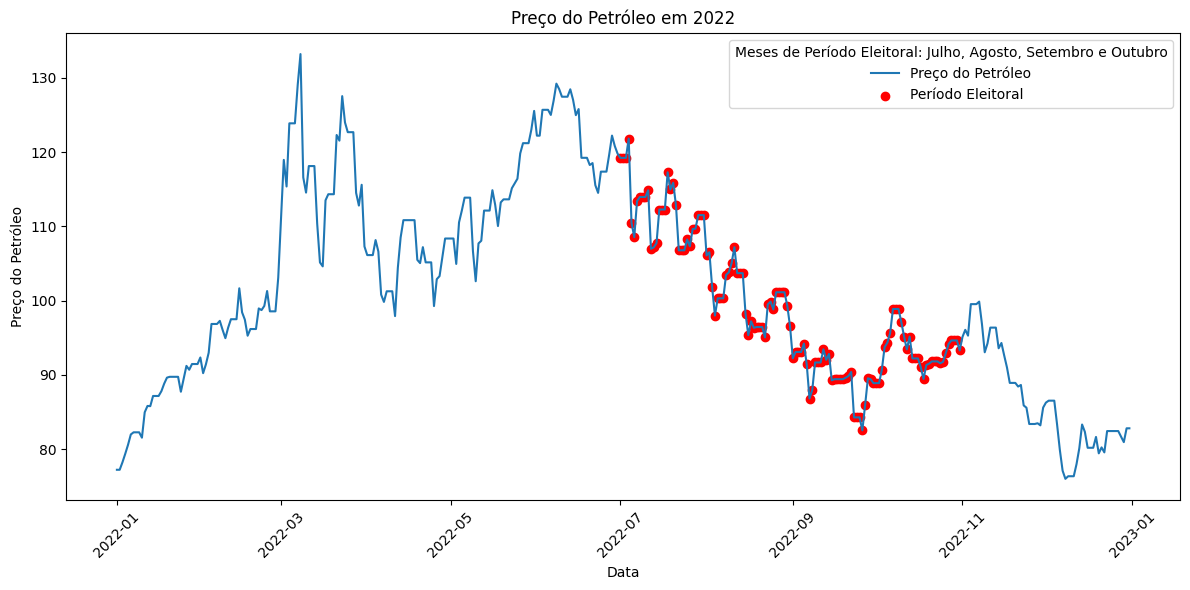

In [52]:


import matplotlib.pyplot as plt

# Filtra os dados para o ano de 2022
df_2022 = df_dados_transformados[df_dados_transformados['ano'] == 2022]

# Cria o gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_2022['data'], df_2022['preco'], label='Preço do Petróleo')

# Adiciona marcadores para os meses de período eleitoral
eleitoral_months = df_2022[df_2022['periodo_eleitoral'] == 1]
plt.scatter(eleitoral_months['data'], eleitoral_months['preco'], color='red', label='Período Eleitoral')

# Configurações do gráfico
plt.xlabel('Data')
plt.ylabel('Preço do Petróleo')
plt.title('Preço do Petróleo em 2022')
plt.xticks(rotation=45)
plt.legend(title='Meses de Período Eleitoral: Julho, Agosto, Setembro e Outubro') # Legenda informando os meses

plt.tight_layout()
plt.show()

## 6 - Visualização dos dados - Séries Temporais


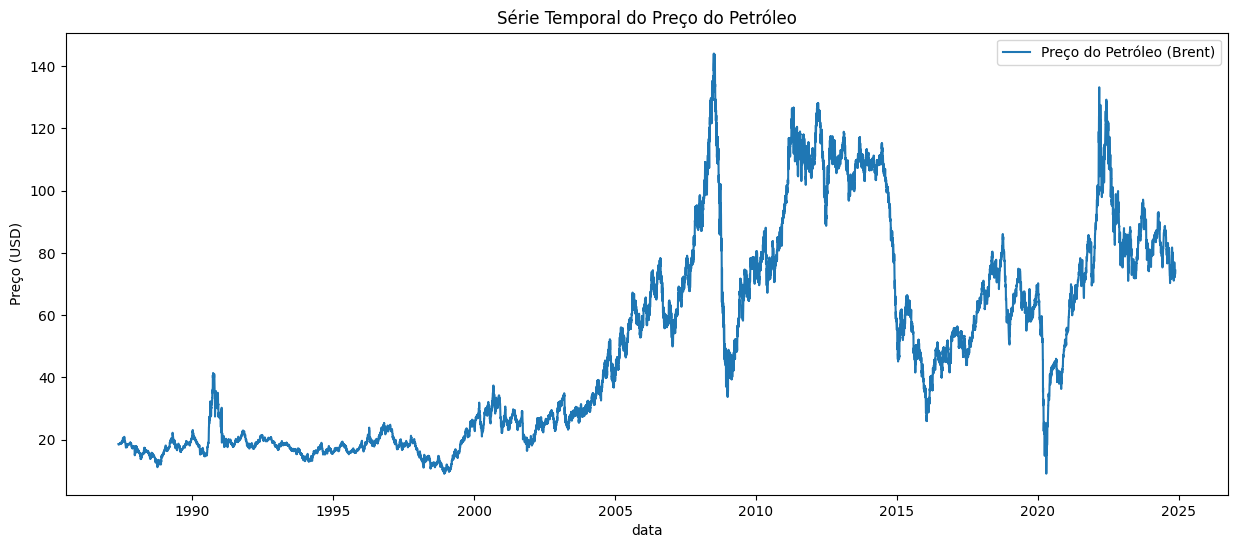

In [ ]:
# Plotando o grafico de todos os anos
plt.figure(figsize=(15, 6))
plt.plot(df_ipea['preco'], label='Preço do Petróleo (Brent)')
plt.title('Série Temporal do Preço do Petróleo')
plt.xlabel('data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()


### 6.1 - Decomposição da série período de **20 anos**

- Vamos trabalhar em cima dos ultimos 20 anos onde ouve uma maior oscilação dos valores

In [ ]:
# Criando um novo df com base nos ultimos 20 anos
df_ipea_20a = df_ipea[(df_ipea.index.year >= 2004) & (df_ipea.index.year <= 2024)]
df_ipea_20a

,preco
data,
2004-01-01,30.30
2004-01-02,29.17
2004-01-03,30.10
2004-01-04,30.30
2004-01-05,32.30
...,...
2024-11-14,73.39
2024-11-15,73.45
2024-11-16,73.45


In [ ]:
media_movel  = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').trend.to_frame()
sazonalidade = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').seasonal.to_frame()
residuo      = df_ipea_20a_decom = seasonal_decompose(df_ipea_20a['preco'], model='additive').resid.to_frame()
template = 'seaborn'

fig = make_subplots(rows = 4, cols = 1)

fig.add_trace(go.Scatter(x = df_ipea_20a.index, y = df_ipea_20a.preco, name = 'Observado', marker = dict(color = '#00008B')), row = 1, col = 1)
fig.add_trace(go.Scatter(x = media_movel.index, y = media_movel.trend, name = 'Media móvel', marker = dict(color = '#B22222')), row = 2, col = 1)
fig.add_trace(go.Scatter(x = sazonalidade.index, y = sazonalidade.seasonal, name = 'Sazonalidade', marker = dict(color = '#008000')), row = 3, col = 1)
fig.add_trace(go.Scatter(x = residuo.index, y = residuo.resid, name = 'Ruido', marker = dict(color = 'gold')), row = 4, col = 1)

fig.update_layout(
    title = {
        'text' : 'Decomposição da Série Preço do Petróleo (Brent) - 20 Anos',
        'x':0.5,
        'xanchor': 'center'
    },
    width = 1100,
    height = 600,
    template = template
)

fig.show()

**Analisando a decomposição da série temporal observamos que :**

> - **Tendência:**  Houve a maior alta no ano de 2008, e a maior queda no ano de 2020 - Será analisado nos topicos abaixo.

> - **Sazonalidade:**   A presença de um padrão repetitivo e regular ao longo dos anos. Isso sugere que fatores específicos a cada mês do ano podem influenciar significativamente o desempenho do índice.

> - **Ruído:** Podemos observar houve alguns pontos que causaram esse ruido .

In [ ]:
# Encontrando o Maior e Menor pico
maior_valor = df_ipea_20a.loc[df_ipea_20a['preco'].idxmax()]
menor_valor = df_ipea_20a.loc[df_ipea_20a['preco'].idxmin()]

print("Maior valor:")
print(maior_valor)

print("\nMenor valor:")
print(menor_valor)

Maior valor:
preco    143.95
Name: 2008-07-03 00:00:00, dtype: float64

Menor valor:
preco    9.12
Name: 2020-04-21 00:00:00, dtype: float64


### 6.2 - Analisando o grafico da media dos meses do anos de 2008 - Maior Variação

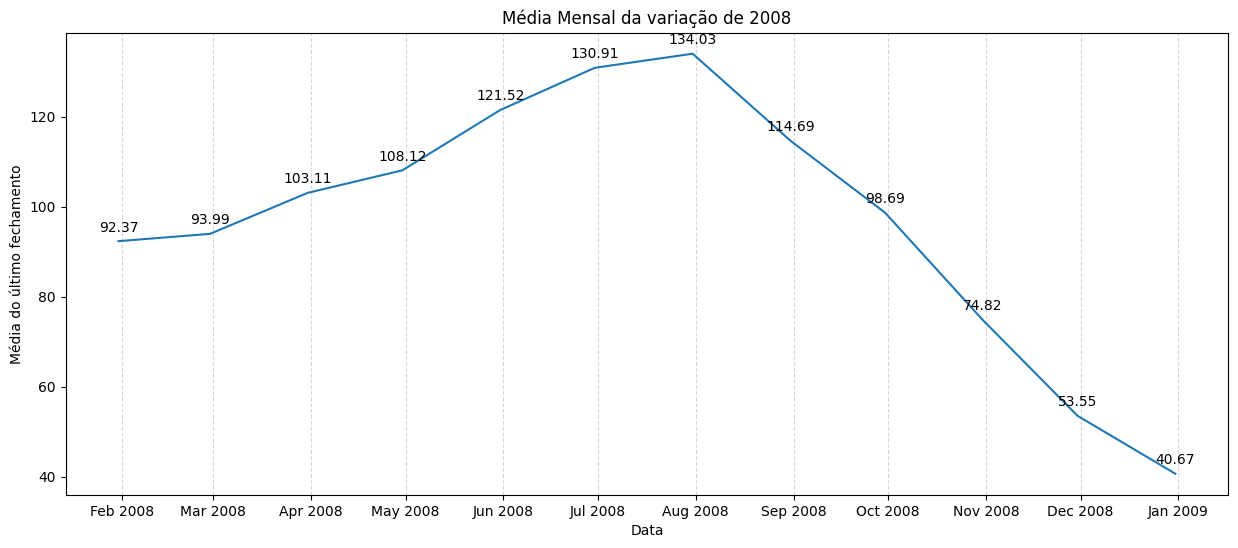

In [ ]:
# DataFrame contendo apenas os dados de 2008 para analisar o maior pico
df_ipea_2008 = df_ipea_20a[df_ipea_20a.index.year == 2008]

# Resample para média mensal
df_ipea_2008_resampled_monthly = df_ipea_2008['preco'].resample('ME').mean()

# Plotar os dados mensais de 2008
plt.figure(figsize=(15, 6))
plt.plot(df_ipea_2008_resampled_monthly.index, df_ipea_2008_resampled_monthly)
plt.title('Média Mensal da variação de 2008')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2008_resampled_monthly.index, df_ipea_2008_resampled_monthly):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,7), ha='center', fontsize=10, color='black')

plt.show()


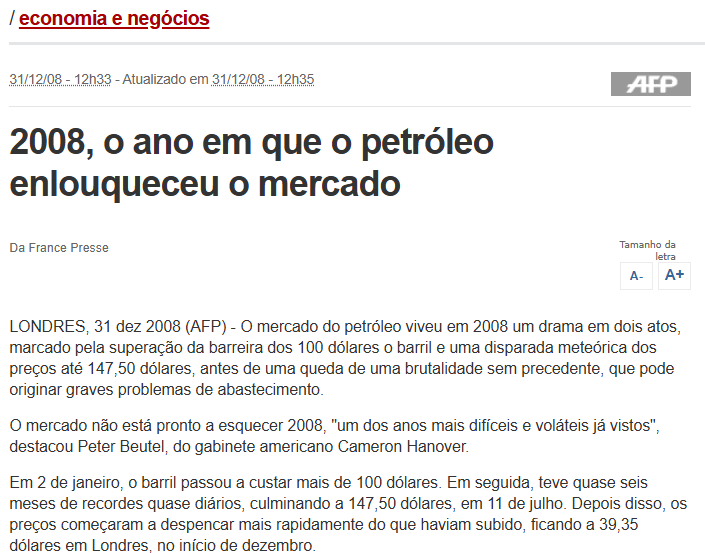




[**2008 - O ano em que o petróleo enlouqueceu o mercado**](https://g1.globo.com/Noticias/Economia_Negocios/0,,MUL940136-9356,00-O+ANO+EM+QUE+O+PETROLEO+ENLOUQUECEU+O+MERCADO.html#:~:text=LONDRES%2C%2031%20dez%202008%20%28AFP%29%20-%20O%20mercado,precedente%2C%20que%20pode%20originar%20graves%20problemas%20de%20abastecimento.
)

### 6.3 - Analisando a média dos meses do anos de 2020 - Menor Media

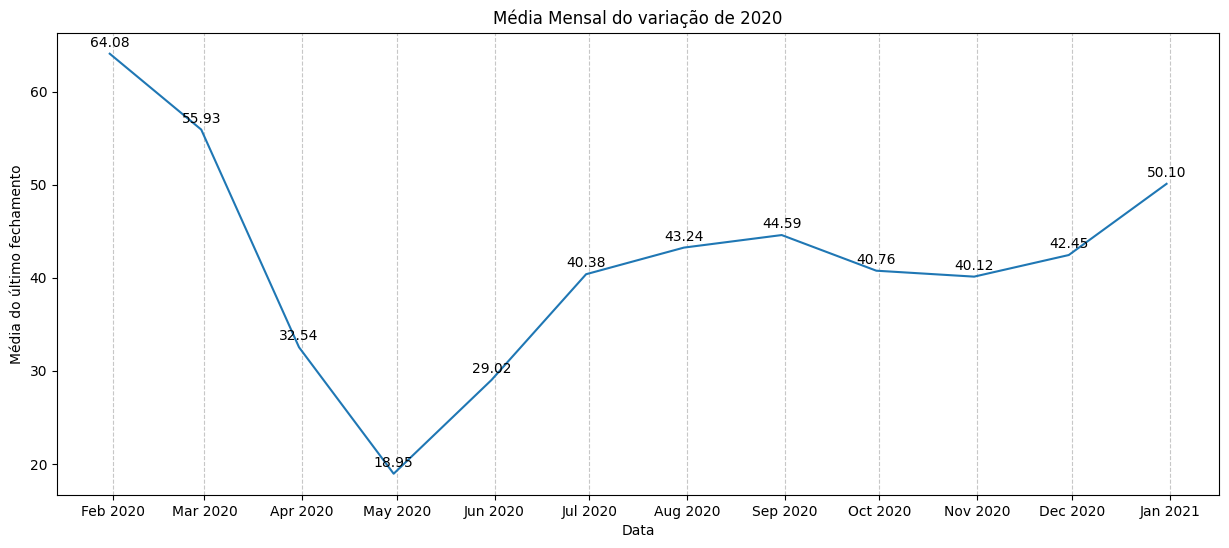

In [ ]:
# DataFrame contendo apenas os dados de 2020 para analisar o menor pico
df_ipea_2020 = df_ipea_20a[df_ipea_20a.index.year == 2020]

# Resample para média mensal
df_ipea_2020_resampled_mes = df_ipea_2020['preco'].resample('ME').mean()

# Plotar os dados mensais de 2020
plt.figure(figsize=(15, 6))
plt.plot(df_ipea_2020_resampled_mes.index, df_ipea_2020_resampled_mes)
plt.title('Média Mensal do variação de 2020')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2020_resampled_mes.index, df_ipea_2020_resampled_mes):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

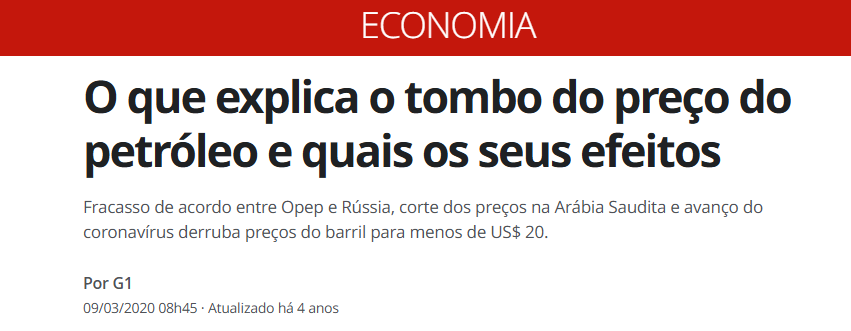


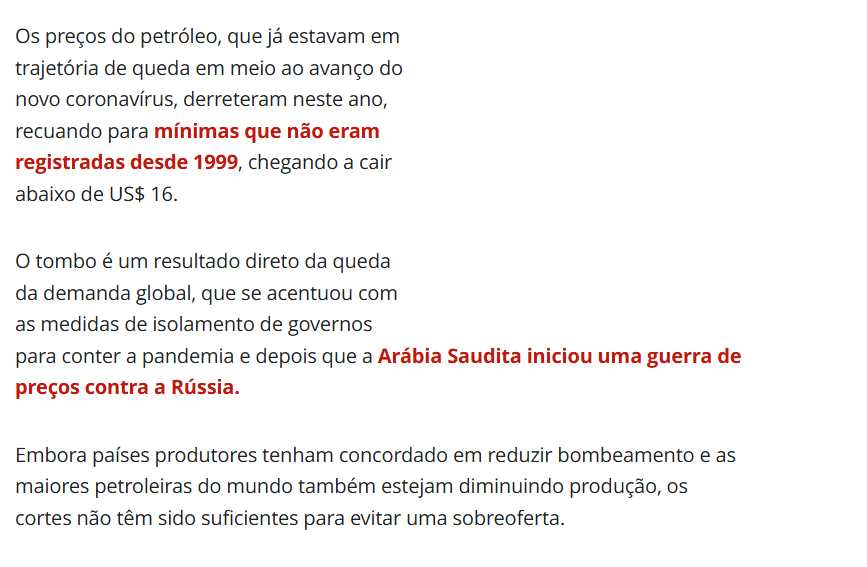

[**2020 - Covid-19 e Queda da demanda global**](https://g1.globo.com/economia/noticia/2020/03/09/o-que-explica-o-tombo-do-preco-do-petroleo-e-quais-os-seus-efeitos.ghtml)

### 6.4 - Analisando a Media dos meses do ano atual

In [ ]:
# Selecionando somente o ano atual
df_ipea_2024 = df_ipea[df_ipea.index.year >= 2024]
df_ipea_2024

,preco
data,
2024-01-01,77.69
2024-01-02,76.24
2024-01-03,77.18
2024-01-04,75.79
2024-01-05,78.31
...,...
2024-11-14,73.39
2024-11-15,73.45
2024-11-16,73.45


In [ ]:
media_movel  = df_ipea_2024_decom = seasonal_decompose(df_ipea_2024['preco'], model='additive').trend.to_frame()
sazonalidade = df_ipea_2024_decom = seasonal_decompose(df_ipea_2024['preco'], model='additive').seasonal.to_frame()
residuo      = df_ipea_2024_decom = seasonal_decompose(df_ipea_2024['preco'], model='additive').resid.to_frame()
template = 'seaborn'

fig = make_subplots(rows = 4, cols = 1)

fig.add_trace(go.Scatter(x = df_ipea_2024.index, y = df_ipea_2024.preco, name = 'Observado', marker = dict(color = '#00008B')), row = 1, col = 1)
fig.add_trace(go.Scatter(x = media_movel.index, y = media_movel.trend, name = 'Media móvel', marker = dict(color = '#B22222')), row = 2, col = 1)
fig.add_trace(go.Scatter(x = sazonalidade.index, y = sazonalidade.seasonal, name = 'Sazonalidade', marker = dict(color = '#008000')), row = 3, col = 1)
fig.add_trace(go.Scatter(x = residuo.index, y = residuo.resid, name = 'Ruido', marker = dict(color = 'gold')), row = 4, col = 1)

fig.update_layout(
    title = {
        'text' : 'Decomposição da Série Preço do Petróleo (Brent) - 2024',
        'x':0.5,
        'xanchor': 'center'
    },
    width = 1100,
    height = 600,
    template = template
)

fig.show()

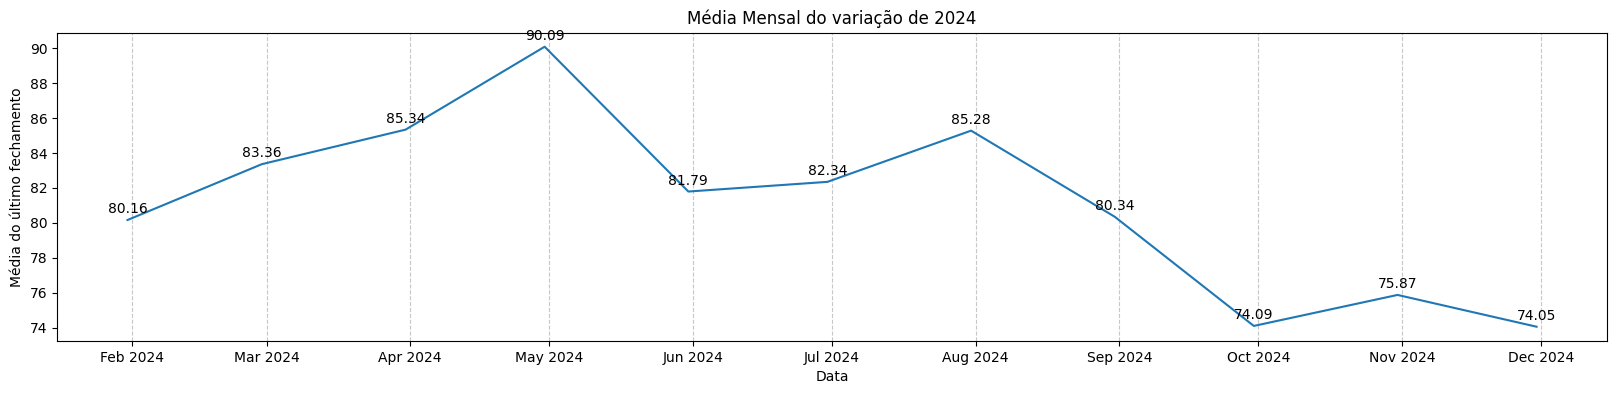

In [ ]:
# Resample para média mensal
df_ipea_2024_resampled_mes = df_ipea_2024['preco'].resample('ME').mean()

# Plotar os dados da media mensal de 2024
plt.figure(figsize=(20, 4))
plt.plot(df_ipea_2024_resampled_mes.index, df_ipea_2024_resampled_mes)
plt.title('Média Mensal do variação de 2024')
plt.xlabel('Data')
plt.ylabel('Média do último fechamento')

# Configurar o formato de data no eixo x para mostrar todos os meses
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

# Adicionar linhas de grade no eixo y
plt.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adicionar rótulos para a quantidade mês a mês
for date, value in zip(df_ipea_2024_resampled_mes.index, df_ipea_2024_resampled_mes):
    plt.annotate(f'{value:.2f}', (date, value), textcoords="offset points", xytext=(0,5), ha='center', fontsize=10, color='black')

plt.show()

In [ ]:
df_ipea_2024_resampled_mes

,preco
data,
2024-01-31,80.158710
2024-02-29,83.358621
2024-03-31,85.336129
2024-04-30,90.085000
2024-05-31,81.790000
2024-06-30,82.344000
2024-07-31,85.278065
2024-08-31,80.343226
2024-09-30,74.091000


## 7 - Analisando a Média Movel

### 7.1 - Teste ADF para estacionaria ou não estacionaria


In [ ]:
x = df_ipea_2024['preco'].values

In [ ]:
resultado = adfuller(x)

print("Teste ADF")
print(f"Teste Estatístico: {resultado[0]}")
print(f"P-value: {resultado[1]}")
print("Valores críticos: ")
print(f"É estacionária: {resultado[1] < 0.05}")

for key, value in resultado[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -1.8283379922074645
P-value: 0.36648616858164146
Valores críticos: 
É estacionária: False
	1%: -3.4508226600665037
	5%: -2.870558121868621
	10%: -2.571574731684734


- Analisando o resultado fica evidente que a serie ainda não esta estacionaria.

- Pois o valor do teste estatístico esta maior que os valores criticos, e nosso p-value não esta proximo do zero

### 7.2 - Transformando a série em estacionaria

In [ ]:
# Criando uma média móvel com base nos últimos 10 e 20 dias.
df_ipea_10_20 = df_ipea_2024

# Odernar por data
df_ipea_10_20 = df_ipea_10_20.sort_index(ascending=False)

#df_ipea_10_20['media_10_dias'] = df_ipea_10_20['preco'].rolling(10).mean() #média móvel em 10 dias
#df_ipea_10_20['media_20_dias'] = df_ipea_10_20['preco'].rolling(20).mean() #média móvel em 10 dias

df_ipea_10_20['media_10_dias'] = df_ipea_10_20['preco'].rolling(10, min_periods=1).mean().shift()
df_ipea_10_20['media_20_dias'] = df_ipea_10_20['preco'].rolling(20, min_periods=1).mean().shift()


df_ipea_10_20.head(30)

,preco,media_10_dias,media_20_dias
data,,,
2024-11-18,74.35,NaN,NaN
2024-11-17,73.45,74.350000,74.350000
2024-11-16,73.45,73.900000,73.900000
2024-11-15,73.45,73.750000,73.750000
2024-11-14,73.39,73.675000,73.675000
2024-11-13,72.86,73.618000,73.618000
2024-11-12,72.56,73.491667,73.491667
2024-11-11,72.19,73.358571,73.358571
2024-11-10,74.04,73.212500,73.212500


- Plotando p gráfico

In [ ]:
fig = px.line(
    df_ipea_10_20['preco'],
    template = template,
    color_discrete_sequence = ['#B22222']
)

fig.add_scatter(
    x = df_ipea_10_20.index,
    y =  df_ipea_10_20['media_10_dias'],
    name = 'Media 10 dias',
    marker = dict(color = '#00008B')
)

fig.add_scatter(
    x = df_ipea_10_20.index,
    y =  df_ipea_10_20['media_20_dias'],
    name = 'Media 20 dias',
    marker = dict(color = '#Ffa500')
)
fig.update_layout(
    title = 'Média Móvel Semanal X Média Móvel 2024 da Pontuação Ibovespa',
    xaxis_title = 'Período',
    yaxis_title = 'Valor Petroleo',
    legend_title = 'Legenda',
    width = 1100,
    height = 600,
    margin = dict(l = 100, r = 20, t = 80, b = 80)
)

fig.show()

In [ ]:
ma = df_ipea_10_20.rolling(7).mean()
ma = ma.rename(columns={'preco': 'Média Semanal'})

df_plot = pd.concat([df_ipea_10_20, ma], axis=1)
df_plot = df_plot.rename(columns={'preco': 'Fechamento Diário'})

fig = px.line(df_plot, x=df_plot.index, y=['Fechamento Diário', 'Média Semanal'])

fig.update_layout(
    title={
        "text" : "Preço do Petroleo",
        'x': 0.5,
        'xanchor': 'center'},
    xaxis_title="Data",
    yaxis_title="Valor do Fechamento",
    legend_title="Legenda",
    width = 1100,
    height = 600,
    margin = dict(l = 100, r = 20, t = 80, b = 80)
)

fig.show()

In [ ]:
df_log = np.log(df_ipea_10_20)
ma_log = df_log.rolling(7).mean()

df_s = (df_log - ma_log).fillna(0)

ma_s = df_s.rolling(7).mean()

std = df_s.rolling(7).std()

# gráfico com Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=df_s.index, y=df_s.iloc[:, 0], mode='lines', name='Log Ajustado'))
fig.add_trace(go.Scatter(x=ma_s.index, y=ma_s.iloc[:, 0], mode='lines', name='Média Móvel', line=dict(color='red')))
fig.add_trace(go.Scatter(x=std.index, y=std.iloc[:, 0], mode='lines', name='Desvio Padrão', line=dict(color='green')))

fig.update_layout(
            title={
                   'text': 'Gráfico com Médias Móveis X Desvio Padrão',
                   'x': 0.5,
                   'xanchor': 'center'
                  },
            xaxis_title='Data',
            yaxis_title='Valor',
            legend_title="Legenda",
            width = 1100,
            height = 600,
            margin = dict(l = 100, r = 20, t = 80, b = 80)
)
fig.show()

In [ ]:
X_s = df_s['preco'].values
result_s = adfuller(X_s)

print("Teste ADF")
print(f"Teste Estatístico: {result_s[0]}")
print(f"P-Value: {result_s[1]}")
print("Valores críticos:")
print(f"É estacionária: {resultado[1] < 0.05}")

for key, value in result_s[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -8.375230154996053
P-Value: 2.597036482723394e-13
Valores críticos:
É estacionária: False
	1%: -3.451082300831733
	5%: -2.87067210822307
	10%: -2.5716355136268345


In [ ]:
df_diff = df_s.diff(1)

ma_diff = df_diff.rolling(7).mean()

std_diff = df_diff.rolling(7).std()


# Criar o gráfico com Plotly
fig = go.Figure()

# Plotando as diferenças de primeira ordem, médias móveis e desvio padrão
fig.add_trace(go.Scatter(x=df_diff.index, y=df_diff.iloc[:, 0], mode='lines', name='Diferença de 1ª Ordem'))
fig.add_trace(go.Scatter(x=ma_diff.index, y=ma_diff.iloc[:, 0], mode='lines', name='Média Móvel (Diferença)', line=dict(color='red')))
fig.add_trace(go.Scatter(x=std_diff.index, y=std_diff.iloc[:, 0], mode='lines', name='Desvio Padrão (Diferença)', line=dict(color='green')))

fig.update_layout(
    title={
        'text': "Gráfico de Diferenças de 1ª Ordem com Médias Móveis e Desvio Padrão",
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Data',
    yaxis_title='Valor',
    width=1300,
    height=600,
    margin=dict(l=100, r=20, t=80, b=80)
)
fig.show()

X_diff = df_diff['preco'].dropna().values
result_diff = adfuller(X_diff)

print("Teste ADF")
print(f"Teste Estatístico: {result_diff[0]}")
print(f"P-Value: {result_diff[1]}")
print("Valores críticos:")

for key, value in result_diff[4].items():
  print(f"\t{key}: {value}")

Teste ADF
Teste Estatístico: -7.995156522943118
P-Value: 2.4152808108545227e-12
Valores críticos:
	1%: -3.452045317832011
	5%: -2.871094805558846
	10%: -2.571860921485457


In [ ]:
lag_acf = acf(df_diff['preco'].dropna(), nlags=40)
lag_pacf = pacf(df_diff['preco'].dropna(), nlags=40)

In [ ]:
# Intervalo de confiança para o ACF/PACF
ci = 1.96/np.sqrt(len(df_s))

trace_acf = go.Scatter(x = np.arange(len(lag_acf)),y = lag_acf, mode='lines', name='ACF')
trace_pacf = go.Scatter(x = np.arange(len(lag_pacf)),y = lag_pacf, mode='lines', name='PACF')

# Linhas de intervalo de confiança superior e inferior
trace_ci_upper = go.Scatter(x = np.arange(len(lag_acf)),y = [ci]*len(lag_acf), mode='lines', name='Limite superior do intervalo de confiança', line=dict(dash='dash', color='gray'))
trace_ci_lower = go.Scatter(x = np.arange(len(lag_acf)),y = [-ci]*len(lag_acf), mode='lines', name='Limite superior do inferior de confiança', line=dict(dash='dash', color='gray'))


fig_acf = go.Figure(data=[trace_acf, trace_ci_upper, trace_ci_lower])
fig_pacf = go.Figure(data=[trace_pacf, trace_ci_upper, trace_ci_lower])

fig_acf.show()
fig_pacf.show()

<Figure size 1200x600 with 0 Axes>

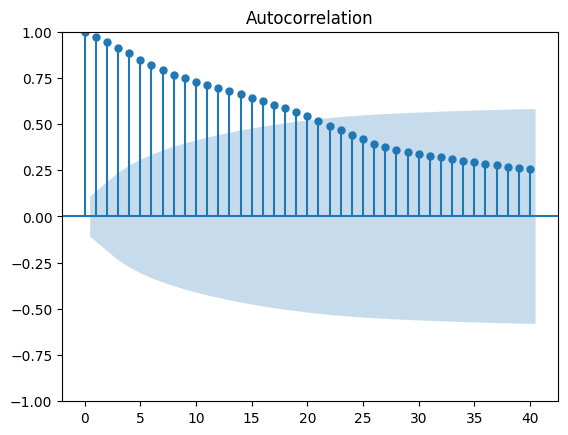

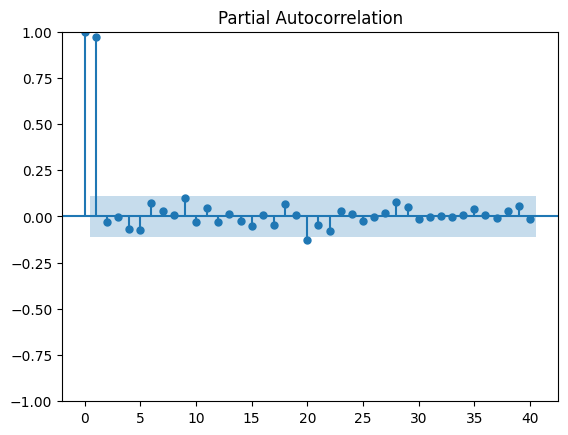

In [ ]:
plt.figure(figsize=(12, 6))

plot_acf(x,lags=40)
plot_pacf(x,lags=40)
plt.show()

In [ ]:
df_diff

,preco,media_10_dias,media_20_dias
data,,,
2024-11-18,NaN,NaN,NaN
2024-11-17,0.000000,0.000000,0.000000e+00
2024-11-16,0.000000,0.000000,0.000000e+00
2024-11-15,0.000000,0.000000,0.000000e+00
2024-11-14,0.000000,0.000000,0.000000e+00
...,...,...,...
2024-01-05,0.002854,0.000411,-7.293822e-05
2024-01-04,-0.024612,0.000843,7.082759e-04
2024-01-03,0.020524,-0.001884,-4.422577e-04


In [ ]:
df_diff.to_csv('df_diff.csv', index=False)

## - Machine

### - Criando métricas para validação dos modelos

- Erro Absoluto Médio (MAE)
- Erro Percentual Médio Absoluto (MAPE)
- Erro Quadrático Médio (MSE)



In [ ]:
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, mse, mape

def print_metrics(metrics):
    mae, mse, mape = metrics
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

In [ ]:
df_diff.reset_index(inplace = True)

In [ ]:
df_diff.reset_index(inplace = True)
df_ipea_prev = df_diff[['data', 'preco','media_10_dias']].rename(columns = {'data': 'ds', 'media_10_dias': 'y'})
df_ipea_prev.dropna(inplace = True)
df_ipea_prev.head(30)

,ds,preco,y
1,2024-11-17,0.000000,0.000000
2,2024-11-16,0.000000,0.000000
3,2024-11-15,0.000000,0.000000
4,2024-11-14,0.000000,0.000000
5,2024-11-13,0.000000,0.000000
6,2024-11-12,-0.010920,0.000000
7,2024-11-11,-0.000901,-0.005107
8,2024-11-10,0.024161,0.000209
9,2024-11-09,-0.001143,0.002411
10,2024-11-08,-0.001143,0.001725


In [ ]:
# Quantidade de linhas no DataFrame
total_linhas = len(df_ipea_prev)

# Dados de treino: todas as linhas exceto as últimas 7
treino = df_ipea_prev.iloc[:total_linhas - 10]

# Dados de validação: as últimas 7 linhas
valida = df_ipea_prev.iloc[total_linhas - 10:]

# h: número de datas únicas na validação
h = valida['ds'].nunique()

# Mostrando os resultados
print("Treino:\n", treino)
print("\nValidação:\n", valida)
print("\nh:", h)

Treino:
             ds     preco         y
1   2024-11-17  0.000000  0.000000
2   2024-11-16  0.000000  0.000000
3   2024-11-15  0.000000  0.000000
4   2024-11-14  0.000000  0.000000
5   2024-11-13  0.000000  0.000000
..         ...       ...       ...
308 2024-01-15 -0.001445 -0.000544
309 2024-01-14  0.003087  0.000576
310 2024-01-13  0.001459  0.000959
311 2024-01-12  0.001459  0.000877
312 2024-01-11  0.005468  0.001046

[312 rows x 3 columns]

Validação:
             ds     preco         y
313 2024-01-10 -0.021297  0.002365
314 2024-01-09 -0.002325 -0.000202
315 2024-01-08 -0.024691 -0.000896
316 2024-01-07  0.039794 -0.003932
317 2024-01-06  0.002854  0.002070
318 2024-01-05  0.002854  0.000411
319 2024-01-04 -0.024612  0.000843
320 2024-01-03  0.020524 -0.001884
321 2024-01-02 -0.009049 -0.000034
322 2024-01-01  0.014699 -0.001077

h: 10


In [ ]:
# Dados de treino
treino = df_ipea_prev.loc[df_ipea_prev['ds'] < '2024-07-13']

# Dados de validação (5 dias), quanto maior o período de predição, maior a largura de banda (maior o erro)
valida = df_ipea_prev.loc[(df_ipea_prev['ds'] >= '2024-07-13') & (df_ipea_prev['ds'] <= '2024-07-22')]
h = valida['data'].nunique()
h

KeyError: 'data'

### Arima

In [ ]:
# 3. Modelo de Previsão - ARIMA
# Separando os dados para treino e teste
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# Treinando o modelo ARIMA
model = ARIMA(train['preco'], order=(5, 1, 0))  # Ajuste os parâmetros (p, d, q)
model_fit = model.fit()

# Previsões
forecast = model_fit.forecast(steps=len(test))
test['Forecast'] = forecast

# Avaliação do Modelo
rmse = np.sqrt(mean_squared_error(test['preco'], test['Forecast']))
print(f'RMSE do Modelo: {rmse}')

# Visualizando Previsões
plt.figure(figsize=(12, 6))
plt.plot(train['preco'], label='Treino')
plt.plot(test['preco'], label='Teste')
plt.plot(test['Forecast'], label='Previsões', linestyle='--')
plt.title('Modelo ARIMA - Previsões vs Dados Reais')
plt.xlabel('Data')
plt.ylabel('Preço (USD)')
plt.legend()
plt.show()

# 4. Exportando o modelo para integração no Streamlit
import pickle
with open('modelo_arima.pkl', 'wb') as f:
    pickle.dump(model_fit, f)

print("Modelo salvo como 'modelo_arima.pkl'")


TypeError: list indices must be integers or slices, not str

### Sarimax

In [ ]:
# Preparar dados para Prophet
treino_prophet = treino.rename(columns={"data": "ds", "fechamento": "y"})
valida_prophet = valida.rename(columns={"data": "ds", "fechamento": "y"})

# Treinar modelo Prophet
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.add_regressor("abertura")
modelo_prophet.fit(treino_prophet)

# Criando o futuro para predição
future = modelo_prophet.make_future_dataframe(periods=len(valida))
future["abertura"] = pd.concat([treino["abertura"], valida["abertura"]], ignore_index=True)
forecast = modelo_prophet.predict(future)

# Criando as Previsões
preds = forecast[["ds", "yhat"]].tail(len(valida))
preds = preds.set_index("ds")
y_test = valida_prophet.set_index("ds")["y"]


metrics_prophet = calculate_metrics(y_test, preds["yhat"])
print("Prophet Metrics:")
print_metrics(metrics_prophet)

ValueError: Regressor 'abertura' missing from dataframe

## streamlit


In [ ]:
df_st = df_ipea_20a.copy()
df_st = df_st.sort_index(ascending=False)
df_st = df_st.reset_index()  # Reseta o índice
df_st['mes'] = df_st['data'].dt.month
df_st['ano'] = df_st['data'].dt.year
df_st = df_st.sort_values(by='data', ascending=True)
df_st['variacao_%'] = round(df_st['preco'].pct_change() * 100, 2)
df_st.head()

,data,preco,mes,ano,variacao_%
7627,2004-01-01,30.30,1,2004,NaN
7626,2004-01-02,29.17,1,2004,-3.73
7625,2004-01-03,30.10,1,2004,3.19
7624,2004-01-04,30.30,1,2004,0.66
7623,2004-01-05,32.30,1,2004,6.60


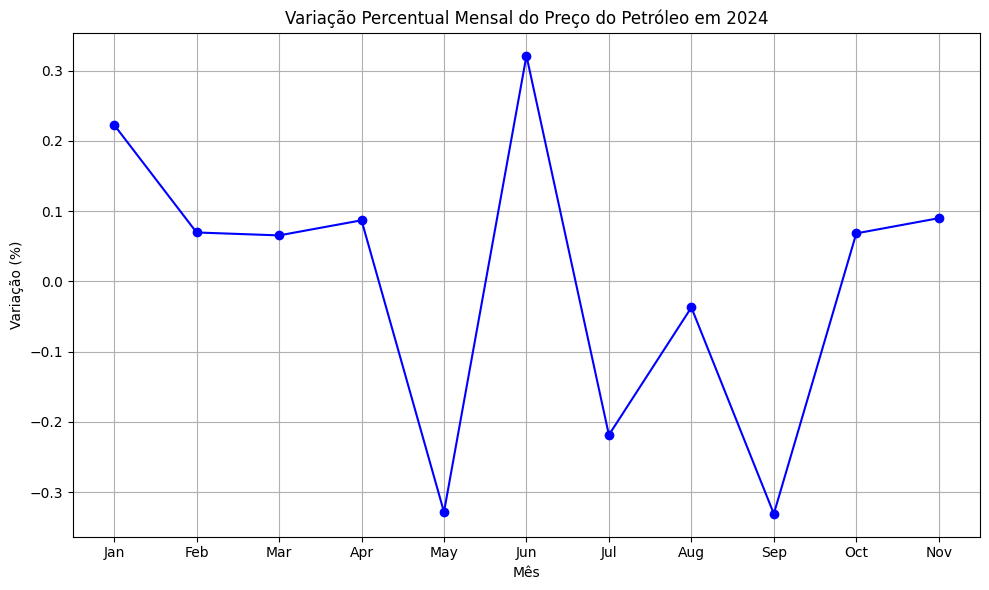

In [ ]:
# Filtrar os dados do último ano
ultimo_ano = df_st['ano'].max()  # Obter o último ano
df_ultimo_ano = df_st[df_st['ano'] == ultimo_ano]

# Agrupar por mês e calcular a variação média
df_ultimo_ano_mensal = df_ultimo_ano.groupby(['ano', 'mes']).agg({'variacao_%': 'mean'}).reset_index()

# Plotar o gráfico da variação percentual por mês
plt.figure(figsize=(10,6))
plt.plot(df_ultimo_ano_mensal['mes'], df_ultimo_ano_mensal['variacao_%'], marker='o', linestyle='-', color='b')
plt.title(f'Variação Percentual Mensal do Preço do Petróleo em {ultimo_ano}')
plt.xlabel('Mês')
plt.ylabel('Variação (%)')
plt.grid(True)

meses_unicos = sorted(df_ultimo_ano_mensal['mes'].unique())

meses_labels = [
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'
][0:len(meses_unicos)]

plt.xticks(meses_unicos, meses_labels)
plt.tight_layout()
plt.show()